# Development of the systems of automatic extraction of the business demands from unstructured texts with NLP

**Proposed system architecture:**

Input Text → NLP Preprocessing → Requirement Detection → Entity & Relation Extraction → Structured Output (JSON/Ontology)

**Metrics:**
- For classification: Accuracy, Precision, Recall, F1-score.
- For extraction: Precision@k, BLEU (for generation), or human evaluation.

**Data Collection:** Kaggle dataset:
- https://www.kaggle.com/datasets/kristian54/business-requirements
- https://www.kaggle.com/datasets/iamvaibhav100/software-requirements-dataset
- 

**Text Preprocessing**: tokenization, lemmatization, stop word removal, sentence segmentation, NER (named entity recognition)


**Feature Engineering, Representation**: TF-IDF, n-grams, syntactic dependencies, Contextual embeddings (BERT, SBERT, etc.)


**Models:**
- Text Classification : (Identify sentences that represent business requirements) BERT, SVM, Logistic Regression
- Named Entity Recognition : (Extract key elements like stakeholder, action, object, constraints) spaCy, HuggingFace Transformers
- Relation Extraction : (Link entities (e.g., “customer” → “needs” → “feature”)) Dependency parsers, transformer-based RE
- Summarization / Generation : (Summarize key demands) PEGASUS, T5, LLM fine-tuning


In [2]:
import pandas as pd

# data = pd.read_csv('../resources/ba/software_requirements_extended.csv')
data = pd.read_csv('../resources/ba/synth_req.csv')

display(data.head())


,Unnamed: 0,RequirementText,Requirement
0,0,we need a mobile application that allows users...,1
1,1,ensure that the new software solution has a us...,1
2,2,we need a mobile application that allows users...,1
3,3,we need a mobile application that allows custo...,1
4,4,we need a mobile application that allows users...,1


In [ ]:
import gensim.downloader as api

corpus = api.load('glove-wiki-gigaword-100')

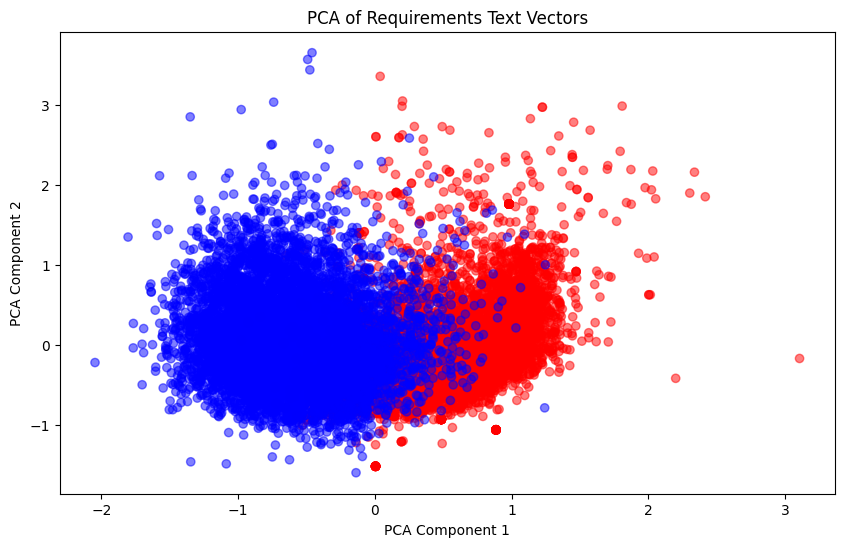

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
import numpy as np

def vectorize_text(text):
    words = word_tokenize(text.lower())
    word_vectors = []
    for word in words:
        if word in corpus:
            word_vectors.append(corpus[word])
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = np.zeros(corpus.vector_size)
    return text_vector

data['Text_Vector'] = data['RequirementText'].apply(str).apply(vectorize_text)
# display(data[['Email Text', 'Text_Vector']].head())

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
text_vectors = np.vstack(data['Text_Vector'].values)
reduced_vectors = pca.fit_transform(text_vectors)
data['PCA_1'] = reduced_vectors[:, 0]
data['PCA_2'] = reduced_vectors[:, 1]

colors = data["Requirement"].map({1: "red", 0: "blue"})

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(data['PCA_1'], data['PCA_2'], c=colors, alpha=0.5)
plt.title('PCA of Requirements Text Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Machine Learning Classification of requirements

In [2]:
import gensim.downloader as api

corpus = api.load('glove-wiki-gigaword-100')

16263 16263


c:\Users\vmelnyk2\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1513
           1       0.97      0.99      0.98      1740

    accuracy                           0.98      3253
   macro avg       0.98      0.98      0.98      3253
weighted avg       0.98      0.98      0.98      3253



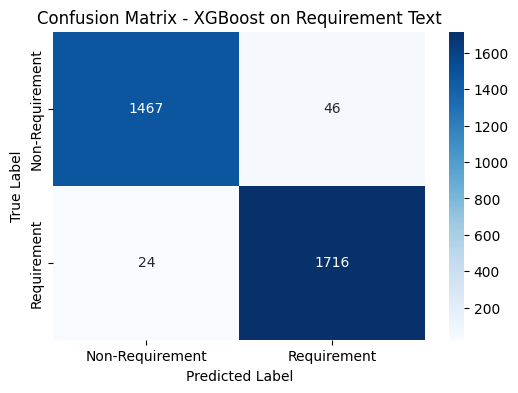

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt

def vectorize_text(text):
    words = word_tokenize(text.lower())
    word_vectors = []
    for word in words:
        if word in corpus:
            word_vectors.append(corpus[word])
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = np.zeros(corpus.vector_size)
    return text_vector

data = pd.read_csv('../resources/ba/synth_req.csv')
data['Text_Vector'] = data['RequirementText'].apply(str).apply(vectorize_text)

X = np.vstack(data['Text_Vector'].values)
y = data['Requirement'].astype(int)
print(len(X), len(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
model = XGBClassifier(
    n_estimators=100,        # number of trees
    learning_rate=0.1,       # step size shrinkage
    max_depth=3,             # depth of trees
    subsample=0.8,           # fraction of samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'   # avoids warning
)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Requirement", "Requirement"], yticklabels=["Non-Requirement", "Requirement"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost on Requirement Text")
plt.show()


### Random forest feature selection + SVM 

,Unnamed: 0,RequirementText,Requirement,Text_Vector
0,0,we need a mobile application that allows users...,1,"[-0.06296654, 0.12647973, 0.21799542, -0.11181..."
1,1,ensure that the new software solution has a us...,1,"[-0.32818902, 0.205139, 0.32688853, -0.0573376..."
2,2,we need a mobile application that allows users...,1,"[-0.08819372, 0.11905001, 0.15533562, -0.12069..."
3,3,we need a mobile application that allows custo...,1,"[0.0064425115, 0.122052886, 0.29702884, -0.038..."
4,4,we need a mobile application that allows users...,1,"[-0.20350568, 0.07153563, 0.05886531, -0.19204..."
5,5,we need a mobile application that allows custo...,1,"[-0.0710448, 0.16082726, 0.258836, -0.09337618..."
6,6,we need a mobile application that allows users...,1,"[-0.26357013, 0.18630356, 0.15048583, -0.17420..."
7,7,we need a mobile application that allows users...,1,"[-0.24749178, 0.043257803, 0.11211581, -0.1798..."
8,8,we need a userfriendly mobile app that allows ...,1,"[-0.045196943, 0.0669765, 0.2904483, -0.119193..."
9,9,we need a userfriendly mobile app that allows ...,1,"[-0.10819311, 0.14860229, 0.24595171, -0.07751..."


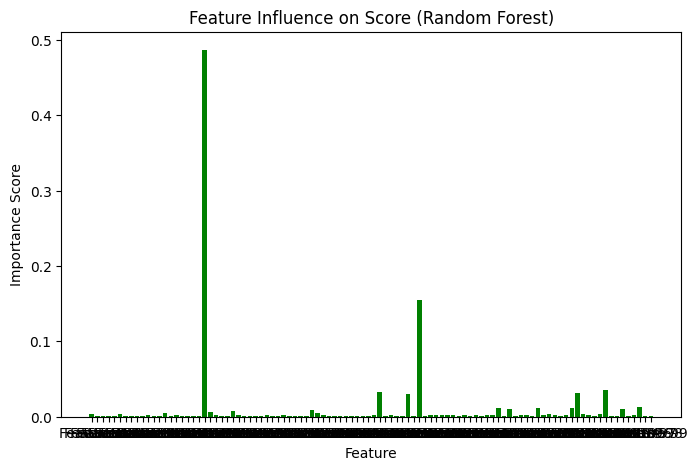

       Feature  Importance
20  Feature 20    0.486644
58  Feature 58    0.155548
91  Feature 91    0.035635
51  Feature 51    0.032164
86  Feature 86    0.032131
56  Feature 56    0.030494
97  Feature 97    0.012803
72  Feature 72    0.012096
85  Feature 85    0.011223
79  Feature 79    0.011081
Top 10 important features (indices): [20, 58, 91, 51, 86, 56, 97, 72, 85, 79]


,Unnamed: 0,RequirementText,Requirement,Text_Vector,Text_Vector_Important
0,0,we need a mobile application that allows users...,1,"[-0.06296654, 0.12647973, 0.21799542, -0.11181...","[-0.03353399, 1.7457234, 0.10046082, 0.0095924..."
1,1,ensure that the new software solution has a us...,1,"[-0.32818902, 0.205139, 0.32688853, -0.0573376...","[-0.201541722, 1.52313042, 0.0383627377, 0.082..."
2,2,we need a mobile application that allows users...,1,"[-0.08819372, 0.11905001, 0.15533562, -0.12069...","[0.03239668, 1.6964394, 0.10030574, 0.03155357..."
3,3,we need a mobile application that allows custo...,1,"[0.0064425115, 0.122052886, 0.29702884, -0.038...","[0.105506644, 1.89594376, 0.0151602682, 0.1199..."
4,4,we need a mobile application that allows users...,1,"[-0.20350568, 0.07153563, 0.05886531, -0.19204...","[0.062736288, 1.8293661, 0.042016521, 0.116760..."
5,5,we need a mobile application that allows custo...,1,"[-0.0710448, 0.16082726, 0.258836, -0.09337618...","[0.0654537007, 1.92938757, 0.0382430814, 0.133..."
6,6,we need a mobile application that allows users...,1,"[-0.26357013, 0.18630356, 0.15048583, -0.17420...","[-0.01079885, 1.7394836, 0.00743597, 0.0327887..."
7,7,we need a mobile application that allows users...,1,"[-0.24749178, 0.043257803, 0.11211581, -0.1798...","[0.0812500194, 1.87342787, 0.0513530076, 0.059..."
8,8,we need a userfriendly mobile app that allows ...,1,"[-0.045196943, 0.0669765, 0.2904483, -0.119193...","[0.20001976, 1.6532621, 0.10015208, 0.12035329..."
9,9,we need a userfriendly mobile app that allows ...,1,"[-0.10819311, 0.14860229, 0.24595171, -0.07751...","[-0.024809994, 1.745406, 0.095384188, 0.195966..."


[-0.06296654  0.12647973  0.21799542 -0.11181106  0.02703093  0.031341
 -0.1879174   0.1431126  -0.037618    0.10258587  0.19256453 -0.18798308
  0.16838667 -0.2858677   0.11006372 -0.20323929  0.25309494  0.25816187
 -0.468416    0.20770265 -0.03353399 -0.20919412  0.23452114  0.16196461
  0.07674877 -0.04727587 -0.02283954 -0.44757664 -0.05969903 -0.12495712
 -0.21931739  0.62488925 -0.22200327  0.1300324   0.35188025  0.21279447
 -0.04807934  0.26062468 -0.16424842 -0.12252944 -0.28381246 -0.21026461
  0.17577712 -0.30165583 -0.1974239   0.02141317  0.11201733 -0.30721006
  0.06398807 -0.6569863   0.06902357  0.00959248 -0.14922339  1.0318828
  0.16700934 -2.1454988   0.08540867 -0.3245507   1.7457234   0.3806108
 -0.16197486  0.38883206 -0.24727128  0.06209308  0.72382736  0.24119881
  0.21760154  0.2790697   0.2844706  -0.37089866  0.08384506 -0.14339213
  0.12296708 -0.6075042   0.23303312  0.08929353 -0.10118067 -0.04425934
 -0.64238656 -0.22294393  0.66418797 -0.01101446 -0.441

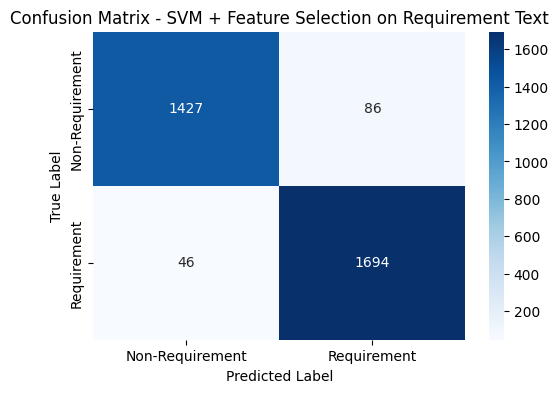

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.svm import SVC

data = pd.read_csv('../resources/ba/synth_req.csv')

def vectorize_text(text):
    words = word_tokenize(text.lower())
    word_vectors = []
    for word in words:
        if word in corpus:
            word_vectors.append(corpus[word])
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = np.zeros(corpus.vector_size)
    return text_vector

def select_top_features(vector: str, indices):
    vector_array = np.fromstring(vector.strip("[]"), sep=" ")
    return vector_array[indices]

data['Text_Vector'] = data['RequirementText'].apply(str).apply(vectorize_text)
display(data.head(10))

X = np.vstack(data['Text_Vector'].values)
y = data['Requirement'].astype(int)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importance_rf = rf.feature_importances_

feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importance_rf, color="green")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Influence on Score (Random Forest)")
plt.show()

# Print feature importance
feature_importance_rf = pd.DataFrame({"Feature": feature_names, "Importance": importance_rf})
print(feature_importance_rf.sort_values(by="Importance", ascending=False)[:10])

feature_dictionary = {i: importance_rf[i] for i in range(len(importance_rf))}
important_features = sorted(feature_dictionary, key=feature_dictionary.get, reverse=True)[:10]
print("Top 10 important features (indices):", important_features)

data['Text_Vector_Important'] = data['Text_Vector'].apply(str).apply(select_top_features, args=([important_features]))
display(data.head(10))

print(data.iloc[0]['Text_Vector'])
print(data.iloc[0]['Text_Vector_Important'])



X = np.vstack(data['Text_Vector_Important'].values)
y = data['Requirement'].astype(int)
print(len(X), len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
model = SVC(kernel="rbf", probability=True, random_state=42)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Requirement", "Requirement"], yticklabels=["Non-Requirement", "Requirement"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM + Feature Selection on Requirement Text")
plt.show()

## Requirements Intelligence System

*Task 1*: clasify if this is a business requirement or not?

**Q**: should we go with binary or multiclass (functional, nfr, constraint, non-requirement: comment|explanation)

How to implement this (if multiclass)?  
- a. TF-IDF + Logistic Regression
- b. DistilBERT / RoBERTa
- c. Fine-tuned BERT on BA corpus

Also: rule-based features (presence of “shall / must / should”, modal verbas, imperative)


*Task 2*: Requirement structuring. Proposed structure (if it is a requirement):

```
{
  "stakeholder": "...", // actor requesting changes, 
  "system": "...", // target system
  "action": "...", // required behaviour ("shall generate", "must validate")
  "object": "...", // data|artifact
  "conditions": "...", // trigger|context ("when user logs in")
  "constraints": "...", // limitation
  "priority": "...", // ("high", "low")
  "quality": "...", // NFR attribute ("secure, scalable")
  "confidence": 0.87 // 
}
```

Application of NER and fuzzy logic here (!)

spaCy Transformer pipeline + custom labels

*Proposed pipeline*:  Raw BA Text -> Sentence segmentation -> Requirement classifier -> (if requieremnt) NER (custom entities) -> Dependency parsing -> Fuzzy logic inference -> Structured requirement


NER alone is not enough. Use dependency relations to: link ACTION → OBJECT; link CONDITION → ACTION; attach CONSTRAINTS

**Q**: How to implement it via spacy? FIGURE OUT!

*Fuzzy logic ineference step*: 

a. interpretation of requirement confidence

Example: `IF (modal_strength is high) AND (actor_present is true) AND (object_present is true) THEN requirement_confidence is high`

**Q**: define variables + rules! How to define rules automatically??

b. Requirement quality: seems easy enough - missing entities, vagueness indicator ("fast", "soon", "nice"), constraints.

c. priority inference!!! `IF (constraint tight) AND (stakeholder critical) THEN priority is high`

Assumptions:
- Precision > recall (false requirements are expensive) (???)
- Human in the loop (?)
- deployment (?)

**Q**: good dataset!

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1513
           1       1.00      0.97      0.98      1740

    accuracy                           0.98      3253
   macro avg       0.98      0.98      0.98      3253
weighted avg       0.98      0.98      0.98      3253

Accuracy: 0.98


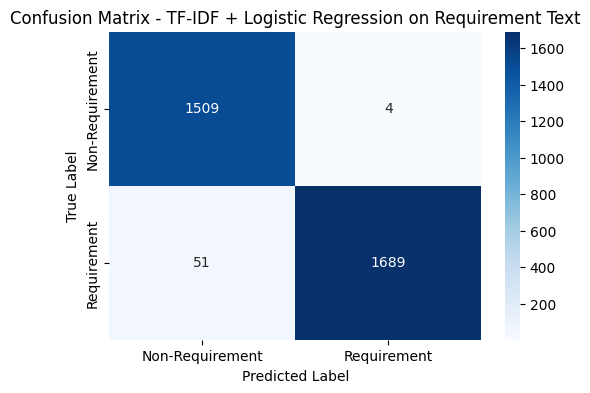

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../resources/ba/synth_req.csv')

X = data['RequirementText'].astype(str)
y = data['Requirement'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words="english", min_df=1)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Requirement", "Requirement"], yticklabels=["Non-Requirement", "Requirement"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression on Requirement Text")
plt.show()
